# Data Module Tutorial

## Table of Contents
---

* [CleanDatasetGenerator class](#cleandataset)
    * [Downloading BSDS dataset](#downloadbsds)
    * [Creating a Clean Dataset](#creating_clean_ds)
    * [Artificial Noising](#artificial-noising)
        * [Gaussian Noise](#gaussian-noise)
        * [Salt and Pepper Noise](#sp-noise)
        * [Super Resolution Noise](#sr-noise)
        * [JPEG artifacts](#jpeg-noise)
        * [Specifying noise types on CleanDatasetGenerator](#specicying-noise-types)
* [FullDatasetGenerator class](#fulldataset)
* [Dataset Factory](#datasetfactory)

In [1]:
# If you are executing this notebook at a location different than the project's root, 
# you need to add it to the path.
import sys
sys.path.insert(0,'../../')

In [2]:
import cv2
import shutil
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from OpenDenoising import data
from skimage.measure import compare_psnr

Using TensorFlow backend.
2019-09-26 15:15:50,367 : WARNING : OpenDenoising.model : Matlab engine was not installed correctly. Take a look on the documentation's tutorial for                           its installation.
2019-09-26 15:15:50,368 : WARNING : OpenDenoising.model : Matlab engine was not installed correctly. Take a look on the documentation's tutorial for                           its installation.


## CleanDatasetGenerator class <a class="anchor" id="cleandataset"></a>
---

Many Deep Learning models for image restoration are trained using __artificial types of noise__. In such setting, one have a dataset of clean images, that is, images without any kind of noise or degradation process. To train the network, these images are noised using artificial noise models, such as __gaussian noise__ or __salt and pepper noise__.

We call these datasets containing only __ground-truth images__ a "clean dataset", and they are handled by the class CleanDatasetGenerator. For mode details on how you can artificially add noise to images, look at the [Artificial Noising](#aritificial-noising) section. 

During this section, we will base our analysis on the dataset used to train DnCNN [[1]](#DnCNN) network. The dataset used is called Berkeley Segmentation Dataset (BSDS) [[2]](#BSDS), consisting of 500 images. For training, BSDS consider 400 cropped images, and further uses 68 images not present on training data for validation/testing.

Additionally, each dataset type has a specific folder structure. We suppose that your Clean Datasets have the following structure:

```
DatasetName/
|-- Train
|   |-- ref
|-- Valid
|   |-- ref
```

### Downloading BSDS data. <a class="anchor" id="downloadbsds"></a>
---

The benchmark include a tool for automatically download the [training](https://github.com/aGIToz/KerasDnCNN/tree/master/genData) and [validation](https://github.com/cszn/DnCNN/blob/master/testsets/BSD68/) datasets from Github pages. These datasets may be further be saved to a "./tmp" folder, as follows:

In [ ]:
data.download_BSDS_grayscale(output_dir="../../tmp/BSDS500/")

### Creating a Clean Dataset <a class="anchor" id="creating_clean_ds"></a>
---

To create a Clean Dataset, you can use the DatasetFactory class by specifying the following parameters:

* batch_size: Following DnCNN's paper [[1]](#DnCNN), the number of patches per batch is 128. However, the batch_size corresponds to the number of images into each batch. Considering a patch size of 40, we end up with 16 times more patches than images. Hence, to end up with 128 patches per batch, we need 8 images per batch.
* n_channels: as our images are grayscale, n_channels = 1
* preprocessing: Following DnCNN's paper [[1]](#DnCNN), we need to extract $40 \times 40$ patches from the images we just downloaded. We can do this by using the function "data.gen_patches".
* name: we will specify "BSDS_Train" as the dataset's name.
* noise_config: Here we can configure the artificial noise that will be added to each image sample $\mathbf{x}$. For our first example, we will add gaussian noise with intensity $\sigma=25$ (always specified with respect to 0-255 range).

In [3]:
batch_size = 8
n_channels = 1
patch_size = 40
noise_config = {data.utils.gaussian_noise: [25]}

preprocessing = [partial(data.gen_patches, patch_size=patch_size)]

With these configurations, you can create your train and valid generators,

In [4]:
# Creating train generator
train_generator = data.DatasetFactory.create(path="../../tmp//BSDS500/Train",
                                             batch_size=batch_size,
                                             n_channels=1,
                                             noise_config=noise_config,
                                             preprocessing=preprocessing,
                                             name="BSDS_Train")

In [5]:
# Creating valid generator
valid_generator = data.DatasetFactory.create(path="../../tmp/BSDS500/Valid",
                                             batch_size=batch_size,
                                             n_channels=1,
                                             noise_config=noise_config,
                                             name="BSDS_Valid")

Notice that we need to specify the path to the root folder, and no to "ref", as the DatasetFactory class does the job of inferring which type of dataset we creating. The "ref" folder, in that case, is the only folder containing images (as we generate noisy images at execution time). Using these two instances of our class, we may generate images that will be fed to Deep Learning models for training and inference,

In [6]:
Ybatch, Xbatch = next(train_generator)

print(Xbatch.shape)
print(Ybatch.shape)

(128, 40, 40, 1)
(128, 40, 40, 1)


As we may see, the batch size is indeed 128. Moreover, the yielded data tensor is always 4D (with last dimension being 1 if images are grayscale). We may also visualize these results,

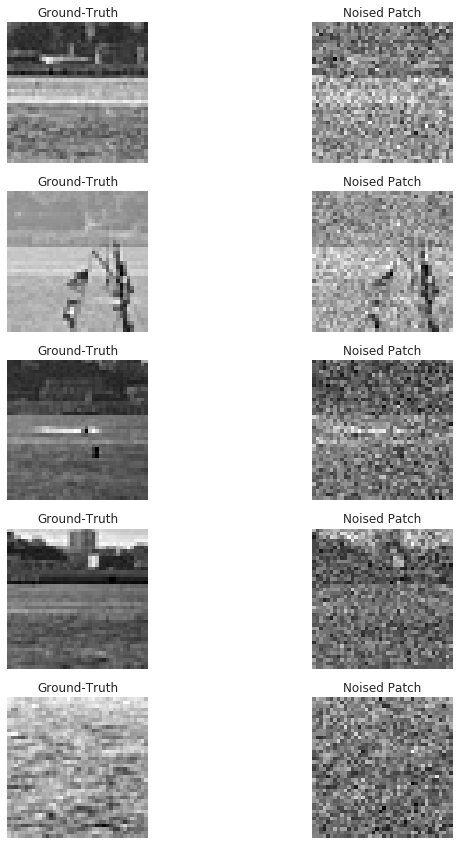

In [7]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i in range(5):
    axes[i, 0].imshow(np.squeeze(Xbatch[i]), cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Ground-Truth")
    
    axes[i, 1].imshow(np.squeeze(Ybatch[i]), cmap="gray")
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Noised Patch")

Simmilarly, for the validation data,

In [8]:
Ybatch, Xbatch = next(valid_generator)

print(Xbatch.shape)
print(Ybatch.shape)

(8, 256, 256, 1)
(8, 256, 256, 1)


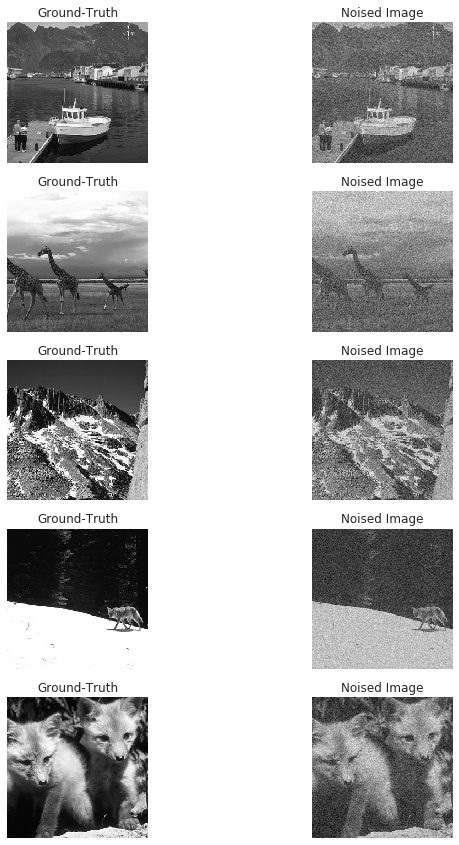

In [9]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i in range(5):
    axes[i, 0].imshow(np.squeeze(Xbatch[i]), cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Ground-Truth")
    
    axes[i, 1].imshow(np.squeeze(Ybatch[i]), cmap="gray")
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Noised Image")

### Artificial Noising. <a class="anchor" id="artificial-noising"></a>
---

In this section we provide the details for adding artificial noise into clean images. First, we cover the basic functions in the __corrupt module__,

#### Gaussian Noise <a class="anchor" id="gaussian-noise"></a>
---

For additive noises, such as the Gaussian Noise, the noised images $\mathbf{y}$ obeys the following expression,

\begin{align}
    \mathbf{y} = \mathbf{x} + \mathbf{\epsilon},
\end{align}

where $\mathbf{x}$ the ground-truth and $\mathbf{\epsilon}$ the noise component. For the Gaussian Noise model, $\mathbf{\epsilon} \sim \mathcal{N}(0, \sigma^{2})$, that is, is an Additive White Gaussian Noise (it is additive, and has zero mean).

The main parameter controlling the level of Gaussian Noise is the variance $\sigma$. Considering its specification, it is noteworthy that the value of $\sigma$, and consequently the impact of such noise on the outcome $\mathbf{y}$ is dependent on the range of the original image $\mathbf{x}$. As a convention, we remark that $\sigma$ should be specified with respect to the uint8 range, that is, \[0, 255\].

In [10]:
x = cv2.imread('../../tmp/BSDS500/Train/ref/test_400.png', 0) # Reads a grayscale image
x = x.astype('float32') / 255 # uint8 => float32

y_1 = data.utils.gaussian_noise(x, noise_level=10)
y_2 = data.utils.gaussian_noise(x, noise_level=15)
y_3 = data.utils.gaussian_noise(x, noise_level=25)
y_4 = data.utils.gaussian_noise(x, noise_level=40)
y_5 = data.utils.gaussian_noise(x, noise_level=50)

print("Degradation level of images (measured in dBs using PSNR):")
print(r"sigma = {}, PSNR = {}".format(10, compare_psnr(y_1, x, data_range=1)))
print(r"sigma = {}, PSNR = {}".format(15, compare_psnr(y_2, x, data_range=1)))
print(r"sigma = {}, PSNR = {}".format(25, compare_psnr(y_3, x, data_range=1)))
print(r"sigma = {}, PSNR = {}".format(40, compare_psnr(y_4, x, data_range=1)))
print(r"sigma = {}, PSNR = {}".format(50, compare_psnr(y_5, x, data_range=1)))

Degradation level of images (measured in dBs using PSNR):
sigma = 10, PSNR = 28.161359453601595
sigma = 15, PSNR = 24.683068666353016
sigma = 25, PSNR = 20.18501822899204
sigma = 40, PSNR = 16.045526696216566
sigma = 50, PSNR = 14.179921020195806


Text(0.5, 1.0, '$\\sigma$=50')

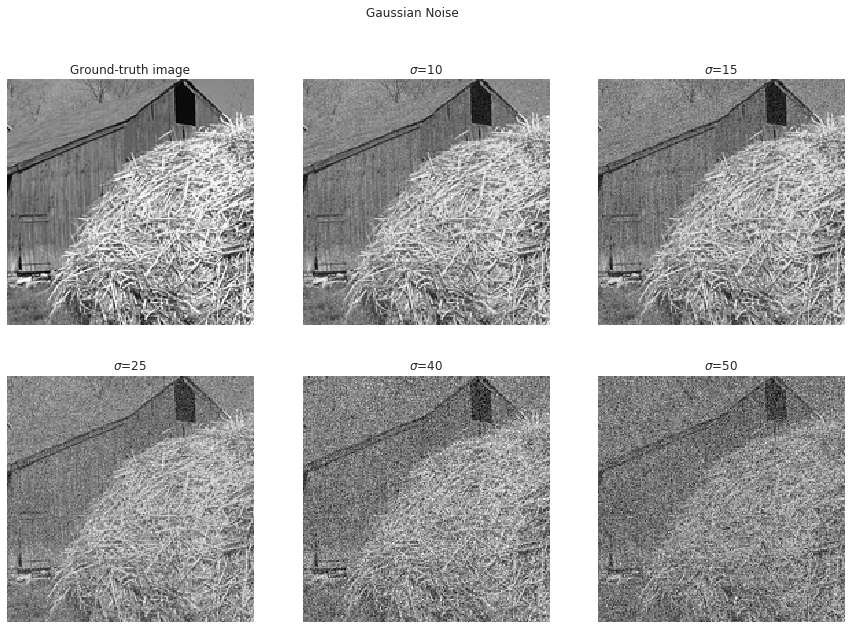

In [11]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plt.suptitle('Gaussian Noise')

axes[0, 0].imshow(x, cmap='gray')
axes[0, 0].axis('off')
axes[0, 0].set_title('Ground-truth image')

axes[0, 1].imshow(y_1, cmap='gray')
axes[0, 1].axis('off')
axes[0, 1].set_title(r'$\sigma$=10')

axes[0, 2].imshow(y_2, cmap='gray')
axes[0, 2].axis('off')
axes[0, 2].set_title(r'$\sigma$=15')

axes[1, 0].imshow(y_3, cmap='gray')
axes[1, 0].axis('off')
axes[1, 0].set_title(r'$\sigma$=25')

axes[1, 1].imshow(y_4, cmap='gray')
axes[1, 1].axis('off')
axes[1, 1].set_title(r'$\sigma$=40')

axes[1, 2].imshow(y_5, cmap='gray')
axes[1, 2].axis('off')
axes[1, 2].set_title(r'$\sigma$=50')

__Remark:__ a similar kind of noise is specified by __data.utils.gaussian_blind_noise__, which is used, for instance, to train the [DnCNN](#DnCNN) network for Blind denoising (noised images only). In that case, the $\sigma$ parameter is drawn uniformly from the range \[$\sigma_{min}$, $\sigma_{max}$\]. The function, hence, accepts two parameters, one for the minimum value of $\sigma$, and other, for its maximum value.

#### Salt and Pepper noise <a class="anchor" id="sp-noise"></a>
---

The salt and pepper noise, also called the shot noise, has a probability $p$ of disturbing a given pixel. Once a pixel is perturbed, it has equal probability of being saturated to either 1, or 0.

To specify the salt and pepper noise, you need to specify its probability of disturbing a pixel.

In [12]:
y_1 = data.utils.salt_and_pepper_noise(x, noise_level=10)
y_2 = data.utils.salt_and_pepper_noise(x, noise_level=15)
y_3 = data.utils.salt_and_pepper_noise(x, noise_level=25)
y_4 = data.utils.salt_and_pepper_noise(x, noise_level=40)
y_5 = data.utils.salt_and_pepper_noise(x, noise_level=50)

print("Degradation level of images (measured in dBs using PSNR):")
print(r"sigma = {}, PSNR = {}".format(10, compare_psnr(y_1, x, data_range=1)))
print(r"sigma = {}, PSNR = {}".format(15, compare_psnr(y_2, x, data_range=1)))
print(r"sigma = {}, PSNR = {}".format(25, compare_psnr(y_3, x, data_range=1)))
print(r"sigma = {}, PSNR = {}".format(40, compare_psnr(y_4, x, data_range=1)))
print(r"sigma = {}, PSNR = {}".format(50, compare_psnr(y_5, x, data_range=1)))

Degradation level of images (measured in dBs using PSNR):
sigma = 10, PSNR = 15.091256472373274
sigma = 15, PSNR = 13.400534711857848
sigma = 25, PSNR = 11.253557466833984
sigma = 40, PSNR = 9.26143142023828
sigma = 50, PSNR = 8.291306232815765


Text(0.5, 1.0, '$p$=50%')

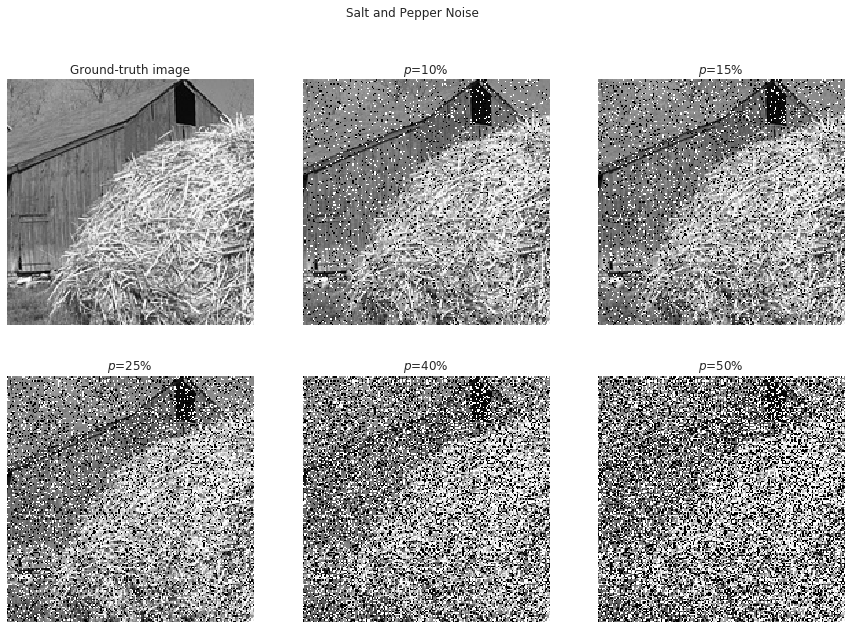

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plt.suptitle('Salt and Pepper Noise')

axes[0, 0].imshow(x, cmap='gray')
axes[0, 0].axis('off')
axes[0, 0].set_title('Ground-truth image')

axes[0, 1].imshow(y_1, cmap='gray')
axes[0, 1].axis('off')
axes[0, 1].set_title(r'$p$=10%')

axes[0, 2].imshow(y_2, cmap='gray')
axes[0, 2].axis('off')
axes[0, 2].set_title(r'$p$=15%')

axes[1, 0].imshow(y_3, cmap='gray')
axes[1, 0].axis('off')
axes[1, 0].set_title(r'$p$=25%')

axes[1, 1].imshow(y_4, cmap='gray')
axes[1, 1].axis('off')
axes[1, 1].set_title(r'$p$=40%')

axes[1, 2].imshow(y_5, cmap='gray')
axes[1, 2].axis('off')
axes[1, 2].set_title(r'$p$=50%')

#### Image Restoration degradations
---

Image Restoration is a broader topic than image denoising, comprehending corruption models that follow a more general expression:

\begin{align}
    \mathbf{y} = \mathbf{H}(\mathbf{x}) + \mathbf{\epsilon},
\end{align}

where $\mathbf{H}$ is called the _degradation operator_. It is clear that when $\mathbf{H}$ is the identity, the denoising problem is restored. Due to their similarity, neural networks may be trained to solve both kinds of problems. Moreover, since the State-of-the-Art is commonly evaluated for both denoising and restoration problems, we have included two of the most common degradation processes: Super Resolution and JPEG Deblocking.

We encourage you to use the terms denoising and restoration, as well as noise and degradation interchangeably througout the dataset.

#### Super Resolution Noise <a class="anchor" id="sr-noise"></a>
---

Super-Resolution is a sub-problem of Image Restoration where we want to resize an image $(h, w)$ to $(n\times h, n\times w)$ while minimizing the quality loss. To train a Deep Neural network to perform such task is equivalent to train a model to restore an image that was deteriorated while performing the resize operation.

To generate images with resolution artifcats, we perform two steps:

1. Take an image of size $[h, w]$. Downsample it using bicubic interpolation to $[h / n, w / n]$.
2. Upsample it using bicubic interpolation back to $[h, w]$.

The resulting image will exhibit low-resolution artifacts, which can be treated as any other kind of artificial noise. The introduction of resolution artifacts in image is done through the function __data.utils.super_resolution_noise__, and the level of degradetaion is controlled through the parameter __noise_level__, which corresponds to the $n$, described in the two steps above.

In [14]:
y_1 = data.utils.super_resolution_noise(x, noise_level=2)
y_2 = data.utils.super_resolution_noise(x, noise_level=3)
y_3 = data.utils.super_resolution_noise(x, noise_level=4)
y_4 = data.utils.super_resolution_noise(x, noise_level=5)
y_5 = data.utils.super_resolution_noise(x, noise_level=6)

print("Degradation level of images (measured in dBs using PSNR):")
print(r"n = {}, PSNR = {}".format(2, compare_psnr(y_1, x, data_range=1)))
print(r"n = {}, PSNR = {}".format(3, compare_psnr(y_2, x, data_range=1)))
print(r"n = {}, PSNR = {}".format(4, compare_psnr(y_3, x, data_range=1)))
print(r"n = {}, PSNR = {}".format(5, compare_psnr(y_4, x, data_range=1)))
print(r"n = {}, PSNR = {}".format(6, compare_psnr(y_5, x, data_range=1)))

Degradation level of images (measured in dBs using PSNR):
n = 2, PSNR = 20.0795335079887
n = 3, PSNR = 16.725544339818022
n = 4, PSNR = 16.291256856862205
n = 5, PSNR = 15.553309213360704
n = 6, PSNR = 15.817223759625026


Text(0.5, 1.0, 'n=6')

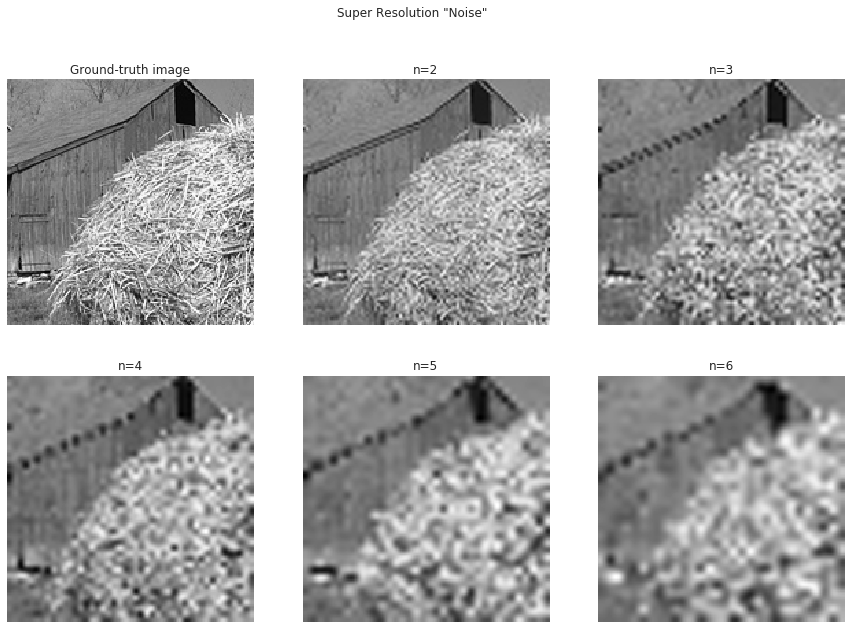

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plt.suptitle('Super Resolution "Noise"')

axes[0, 0].imshow(x, cmap='gray')
axes[0, 0].axis('off')
axes[0, 0].set_title('Ground-truth image')

axes[0, 1].imshow(y_1, cmap='gray')
axes[0, 1].axis('off')
axes[0, 1].set_title(r'n=2')

axes[0, 2].imshow(y_2, cmap='gray')
axes[0, 2].axis('off')
axes[0, 2].set_title(r'n=3')

axes[1, 0].imshow(y_3, cmap='gray')
axes[1, 0].axis('off')
axes[1, 0].set_title(r'n=4')

axes[1, 1].imshow(y_4, cmap='gray')
axes[1, 1].axis('off')
axes[1, 1].set_title(r'n=5')

axes[1, 2].imshow(y_5, cmap='gray')
axes[1, 2].axis('off')
axes[1, 2].set_title(r'n=6')

#### JPEG Compression noise <a class="anchor" id="jpeg-noise"></a>
---

As sub-resolution, JPEG deblocking is another kind of image restoration task, where we want to restore an image that was degraded by compressing it using JPEG algorithm. The introduction of JPEG artifcats in the image is done by using __data.utils.jpeg_artifacts__.  It has one parameter, controlling the intensity of compression, which is __compression_rate__ (given as a percentage of information lost).

In [16]:
y_1 = data.utils.jpeg_artifacts(x, compression_rate=50)
y_2 = data.utils.jpeg_artifacts(x, compression_rate=25)
y_3 = data.utils.jpeg_artifacts(x, compression_rate=10)
y_4 = data.utils.jpeg_artifacts(x, compression_rate=5)
y_5 = data.utils.jpeg_artifacts(x, compression_rate=1)

print("Degradation level of images (measured in dBs using PSNR):")
print(r"compression_rate = {}%, PSNR = {}".format(50, compare_psnr(y_1, x, data_range=1)))
print(r"compression_rate = {}%, PSNR = {}".format(75, compare_psnr(y_2, x, data_range=1)))
print(r"compression_rate = {}%, PSNR = {}".format(90, compare_psnr(y_3, x, data_range=1)))
print(r"compression_rate = {}%, PSNR = {}".format(95, compare_psnr(y_4, x, data_range=1)))
print(r"compression_rate = {}%, PSNR = {}".format(99, compare_psnr(y_5, x, data_range=1)))

Degradation level of images (measured in dBs using PSNR):
compression_rate = 50%, PSNR = 25.951901705990533
compression_rate = 75%, PSNR = 22.98954860230411
compression_rate = 90%, PSNR = 20.50408531353633
compression_rate = 95%, PSNR = 18.869556088687595
compression_rate = 99%, PSNR = 17.60146997117809


Text(0.5, 1.0, 'compression_rate=90')

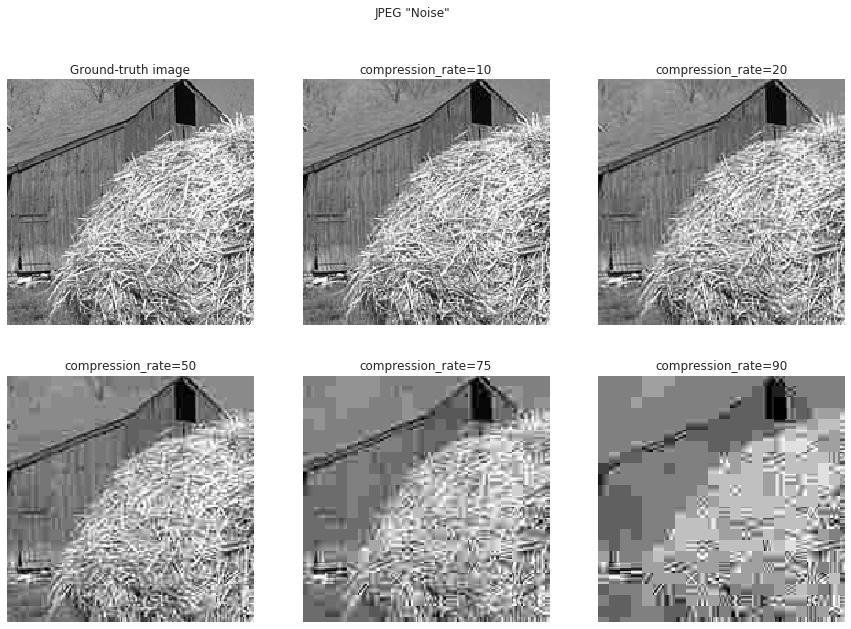

In [17]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

plt.suptitle('JPEG "Noise"')

axes[0, 0].imshow(x, cmap='gray')
axes[0, 0].axis('off')
axes[0, 0].set_title('Ground-truth image')

axes[0, 1].imshow(y_1, cmap='gray')
axes[0, 1].axis('off')
axes[0, 1].set_title(r'compression_rate=10')

axes[0, 2].imshow(y_2, cmap='gray')
axes[0, 2].axis('off')
axes[0, 2].set_title(r'compression_rate=20')

axes[1, 0].imshow(y_3, cmap='gray')
axes[1, 0].axis('off')
axes[1, 0].set_title(r'compression_rate=50')

axes[1, 1].imshow(y_4, cmap='gray')
axes[1, 1].axis('off')
axes[1, 1].set_title(r'compression_rate=75')

axes[1, 2].imshow(y_5, cmap='gray')
axes[1, 2].axis('off')
axes[1, 2].set_title(r'compression_rate=90')

#### Specifying Noise types on CleanDatasetGenerator <a class="anchor" id="specicying-noise-types"></a>
---

In the CleanDatasetGenerator, noise is artificially added to images at each time an image is read from memory. __You should keep in mind that, if your noising function introduces too much overhead into the batch generation process, you should avoid specifying it__. Instead, if that is the case, you can add noise to the images, then save the noised ones on $(\$DATASETPATH)/in/$ and use them as if they were a "FullDataset" (see bellow).

Each CleanDatasetGenerator has an internal dictionary of noising functions. This dictionary consists of pairs "function: args", where function is the noising function that will corupt the data, and args are the arguments for it. You can specify more than one noise, knowing that they will be applied sequentially, as can be seen bellow,

In [18]:
noise_config = {
    data.utils.gaussian_blind_noise: [0, 55],
    data.utils.salt_and_pepper_noise: [10]
}

In [19]:
valid_generator = data.DatasetFactory.create(path="../../tmp/BSDS500/Valid",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config=noise_config,
                                             name="BSDS_Valid")

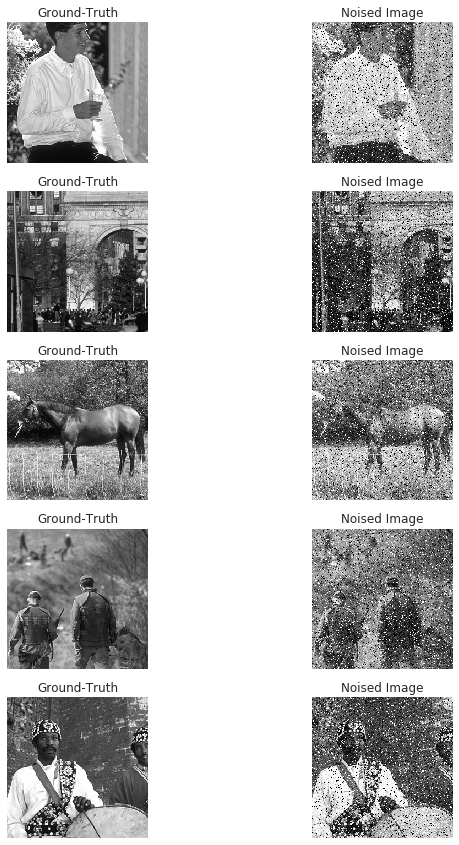

In [20]:
Ybatch, Xbatch = next(valid_generator)
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i in range(5):
    axes[i, 0].imshow(np.squeeze(Xbatch[i]), cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Ground-Truth")
    
    axes[i, 1].imshow(np.squeeze(np.clip(Ybatch[i], 0, 1)), cmap="gray")
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Noised Image")

## FullDatasetGenerator class <a class="anchor" id="fulldataset"></a>

Some other datasets happen to have matched image pairs $\mathbf{x}_{i}, \mathbf{y}_{i}$. In that case, instead of generating an artificial noise to train the dataset, we may use the pairs for training Deep Learning Model, as well as to assess model quality. Full Datasets need to have the following folder structure,

```
DatasetName/
|-- Train
|   |-- in
|   |-- ref
|-- Valid
|   |-- in
|   |-- ref
```

Here we use as example the PolyU real-world denoising dataset [[3]](#PolyU). You can either download it from their [Github page](https://github.com/csjunxu/PolyU-Real-World-Noisy-Images-Dataset), or use the data module to automatically download it,

In [ ]:
polyu_path = "../../tmp/PolyU/"
data.download_PolyU(polyu_path)

The procedure for creating Full Datasets is quite the same, the only difference being that we do not have to specify the noise config dictionary. Since DatasetFactory receives the dataset root, it automatically recognizes images in "ref" as the ground_truth, and images in "in" as the noisy samples, as shown bellow,

In [21]:
polyU_cropped = data.DatasetFactory.create(path="../../tmp/PolyU/Train",
                                           batch_size=16,
                                           n_channels=3,
                                           name="PolyU_Cropped")

In [22]:
Ybatch, Xbatch = next(polyU_cropped)

print(Xbatch.shape)
print(Ybatch.shape)

(16, 512, 512, 3)
(16, 512, 512, 3)


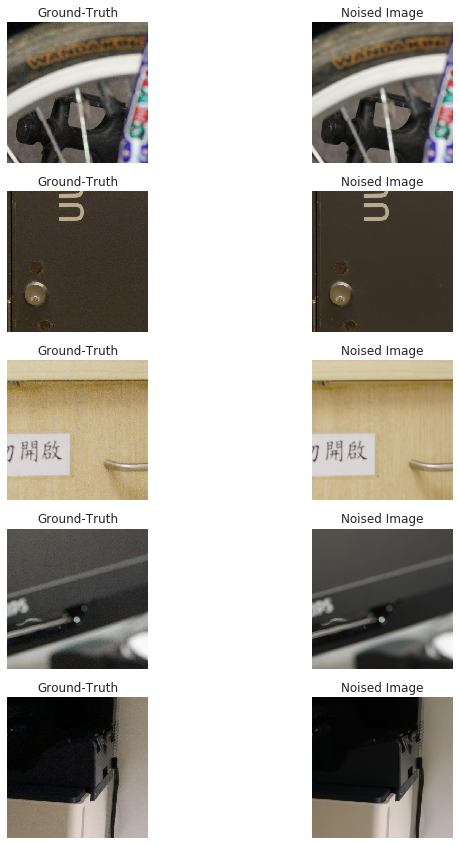

In [23]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i in range(5):
    axes[i, 0].imshow(np.squeeze(Xbatch[i]), cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Ground-Truth")
    
    axes[i, 1].imshow(np.squeeze(Ybatch[i]), cmap="gray")
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Noised Image")

## Blind Datasets

We also offer the posibility to specify blind datasets for image denoising. These types of datasets are used, for instance, in algorithms such as GCBD [[4]](#GCBD) and Noise2Void [[5]](#Noise2Void).

These algorithms, however, may or may not rely only on noisy images. For the first case, we consider the unsupervised part of GCBD: a GAN is used to model the noise distribution. In that case, only noisy images are used.

For Noise2Void, however, a pairing still needs to be done. In the specific case of Noise2Void, random pixels are substituted by a random value in order to prohibit a neural network to learn the identity function. In order to generate the pairing, you can specify a **target generation function** (*target\_fcn* parameter), which behaves simillarly to corruption functions in Clean datasets. These functions can be specified, so that neural networks can still perform supervised learning on data.

As an example we use here the Noise2Void pipeline to demonstrate how to use Blind Datasets. We remark that the code provided by our benchmark is a version based on the [author's original code](https://github.com/juglab/n2v) with few modifications. 

For this example, we generate the noisy images by adding gaussian noise to BSDS500 images, and then saving them to a new folder.

In [ ]:
PATH_TO_IMGS = '../../tmp/BSDS500/Train/ref'
PATH_TO_SAVE = '../../tmp/BlindExample/Train/'
data.generate_full_dataset(PATH_TO_IMGS, PATH_TO_SAVE, noise_config={data.gaussian_noise: [25]},
                           preprocessing=[])
shutil.rmtree('../../tmp/BlindExample/Train/ref')

To create your dataset, you only need to use the **DatasetFactory** object, while specifying the *target_fcn* function (if you will perform supervised learning).

In [24]:
blind_dataset = data.DatasetFactory.create(path="../../tmp/BlindExample/Train",
                                           batch_size=16,
                                           n_channels=1,
                                           target_fcn=data.n2v_data_generation,
                                           name="Noise2VoidDataset")

Notice that the return of this dataset generator is quite different from other methods. First, the target images are not clean version of input images (since
they are assumed unavailable), but rather a masked version of the input. For more information, that a look on Noise2Void paper.

In [26]:
Ybatch, Xbatch = next(blind_dataset)

print(Xbatch.shape)
print(Ybatch.shape)

(16, 180, 180, 2)
(16, 180, 180, 1)


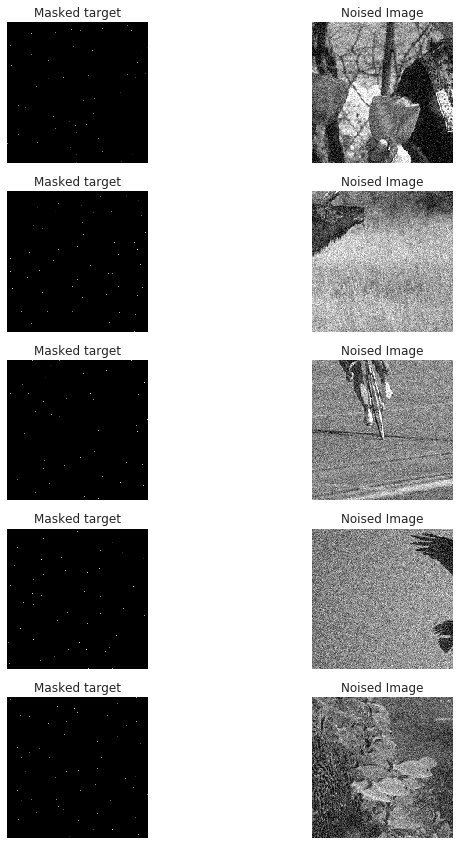

In [28]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for i in range(5):
    axes[i, 0].imshow(np.squeeze(Xbatch[i, :, :, 0]), cmap="gray")
    axes[i, 0].axis("off")
    axes[i, 0].set_title("Masked target")
    
    axes[i, 1].imshow(np.squeeze(Ybatch[i]), cmap="gray")
    axes[i, 1].axis("off")
    axes[i, 1].set_title("Noised Image")

References
---

[[1]](https://arxiv.org/pdf/1608.03981.pdf)<a class="anchor" id="DnCNN"></a> Zhang, K., Zuo, W., Chen, Y., Meng, D., & Zhang, L. (2017). Beyond a gaussian denoiser: Residual learning of deep cnn for image denoising. IEEE Transactions on Image Processing

[[2]](https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/papers/mftm-iccv01.pdf)<a class="anchor" id="BSDS"></a> Martin, D., Fowlkes, C., Tal, D., & Malik, J. (2001, July). A database of human segmented natural images and its application to evaluating segmentation algorithms and measuring ecological statistics. Vancouver:: Iccv.

[[3]](https://arxiv.org/pdf/1804.02603.pdf)<a class="anchor" id="PolyU"></a> Xu, J., Li, H., Liang, Z., Zhang, D., & Zhang, L. (2018). Real-world noisy image denoising: A new benchmark. arXiv preprint arXiv:1804.02603.

[[4]](http://openaccess.thecvf.com/content_cvpr_2018/papers/Chen_Image_Blind_Denoising_CVPR_2018_paper.pdf)<a class="anchor" id="GCBD"></a> Chen, J., Chen, J., Chao, H., & Yang, M. (2018). Image blind denoising with generative adversarial network based noise modeling. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.

[[5]](https://arxiv.org/abs/1811.10980)<a class="anchor" id="Noise2Void"></a> Krull, A., Buchholz, T. O., & Jug, F. (2019). Noise2void-learning denoising from single noisy images. In Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition.
